<a href="https://colab.research.google.com/github/mcnica89/MATH4060/blob/main/ActorCritic_CartPole_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code shows an example of using the Actor-Critic method on the CartPole problem. In this problem you are a cart and you need to balance a pole vertically above you. See https://gym.openai.com/envs/CartPole-v1/ for details on this environment

The descritpion from the OpenAI gym reads: 
> "A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center."

#Import Packages



In [1]:
!pip install -q gym-notebook-wrapper
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
import gnwrapper
import gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import time
from gym.core import RewardWrapper

# Cart Pole simulations with purely random policy

In [3]:
def pure_random_policy(key, obs):
  '''A purely random policy for carpole!'''
  probs = jnp.array([0.5,0.5])
  action = jax.random.choice(key, jnp.array([0,1]), p=probs)
  return int( action )

def simulate_cartpole(key, Policy, N_episodes = 100, Render = False):
  '''Simulates runs of carpole using the provided policy. Render = True will draw pics! Returns average reward per episode over N_episodes'''

  #Set the environment and variables
  env = gnwrapper.Animation(gym.make('CartPole-v1'))
  obs = env.reset()
  episode_num = 0
  total_rewards = 0

  #Loop until N_episodes have run
  while episode_num < N_episodes:

    #Choose an action according to policy
    key, subkey = jax.random.split(key)
    action = Policy(subkey, obs)

    #Take that action and observe next state from the environment
    obs, reward, done, info = env.step(action)

    #Keep track of total rewards
    total_rewards += reward

    if Render:
      #Draw the picture!
      print("Action: ", action)
      print("Obs: ", obs)
      print("Done: ", done)
      env.render()

    if done:
      #Reset the environment if we are done
      episode_num += 1
      obs = env.reset()
      if Render:
        print("---DONE!---")
      

  return total_rewards/N_episodes

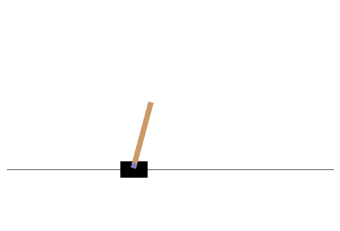

---DONE!---
The reward we got was  45.0


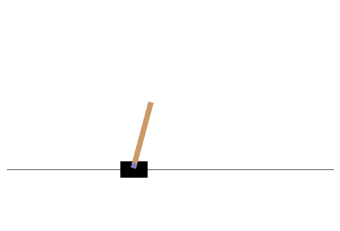

In [4]:
#Simulate 1 epsiode and animate it!
print("Purely random policy!")
key = jax.random.PRNGKey(0)
reward = simulate_cartpole(key, pure_random_policy, 1, True)
print("The reward we got was ", reward)

In [5]:
#Simulate N_episodes and output the average reward
N_episodes = 100
print("Simulating ", N_episodes, " episodes of pure random policy...")

key = jax.random.PRNGKey(0)
average_reward = simulate_cartpole(key, pure_random_policy, N_episodes, False)
print("Average reward over ", N_episodes," episodes is ", average_reward)

Simulating  100  episodes of pure random policy...
Average reward over  100  episodes is  24.07


# Setting up some functions for Actor-Critic methods

In [6]:
#This code sets up functions for the actor and critic in terms of functions actor_func
#We use neural networks with one hidden layer for these

N_inputs = 4 #Size of the observations
N_hidden = 128 #Number of neurons in hidden layer
N_actions = 2 #Number of possible actions (size of output probability vector)

@jax.jit
def actor_func(hidden_layer_weights, hidden_layer_biases, actor_weights, input):
  '''Outputs the probabilities for the actor based on the weights'''
  #Input: 
  #  hidden_layer_weights = A matrix of shape (N_hidden, N_input)
  #  hidden_layer_biases = A vector of shape (N_hidden,)
  #  actor_weights = A vector of shape (N_actions, N_hidden) 
  #  input =A vector of shape (N_hidden,)
  #
  #Output: A probabilty vector of shape (N_actions,)
  #
  #Note: things are normalized so that the weights/biases should be O(1) regardless of the size of N_hidden

  #The hidden layer is just matrix multiplication and vector addition followed by an entriwise non-linearity
  hidden_layer = jax.nn.relu(hidden_layer_weights @ input / jnp.sqrt(N_inputs) + hidden_layer_biases)

  #The final answer is again matrix multiplication followed by softmax to convert to probabilities.
  actor = jax.nn.softmax( actor_weights @ hidden_layer / jnp.sqrt(N_hidden) )
  return actor

#We also use JAX to automatically find the derivative of the log(actor_func) which is used in the policy update
#Note that we have to also plug in action = 0 or action=1 for this
#This means we actually get a tuple with 2 functions in it
log_actor_funcs = (lambda x,y,z,o : jnp.log(actor_func(x,y,z,o)[0]) , lambda x,y,z,o : jnp.log(actor_func(x,y,z,o)[1]) )
grad_log_actor_funcs = jax.jit(jax.grad(log_actor_funcs[0], argnums=(0,1,2))), jax.jit(jax.grad(log_actor_funcs[1], argnums=(0,1,2)))

@jax.jit
def critic_func(hidden_layer_weights, hidden_layer_biases, critic_weights, critic_bias, input):
   '''Outputs an estimate for the value of the current state based on the weights'''
   #Input: 
   #  hidden_layer_weights = A matrix of shape (N_hidden, N_input)
   #  hidden_layer_biases = A vector of shape (N_hidden,)
   #  critic_weights = A vector of shape (N_hidden,)
   #  input =A vector of shape (N_actions, N_hidden)
   #
   #Output: A probabilty vector of shape (N_actions,)
   #
   #Note: things are normalized so that the weights/biases should be O(1) regardless of the size of N_hidden

   #The hidden layer is just matrix multiplication and vector addition followed by an entriwise non-linearity
   hidden_layer = jax.nn.relu(hidden_layer_weights @ input / jnp.sqrt(N_inputs) + hidden_layer_biases)
   
   #The final value is a linear combination of the hidden layer
   critic = critic_weights @ hidden_layer / jnp.sqrt(N_hidden) + critic_bias
   return critic

#Find the gradient of the critic function for use in updating the weights
#Note: We speed up the computations with jax.jit
grad_critic_func = jax.jit(jax.grad(critic_func,argnums=(0,1,2,3)))

In [7]:
#Initialize weights to random values and test out the functions
key = jax.random.PRNGKey(int(time.time()))
keys = jax.random.split(key ,4)
key = keys[0]

actor_hl_b = jax.random.normal(keys[1], (N_hidden,) ) / 100
actor_hl_w = jax.random.normal(keys[2], (N_hidden, N_inputs)) / 100 
actor_w = jax.random.normal(keys[3], (N_actions, N_hidden)) / 100

keys = jax.random.split(key ,5)
key = keys[0]
critic_hl_b = jax.random.normal(keys[1], (N_hidden,) )
critic_hl_w = jax.random.normal(keys[2], (N_hidden, N_inputs))  
critic_w = jax.random.normal(keys[3], (N_hidden,) )
#We set the critic bias to 22 since this is approximately the average value 
# of the purely random policy. That way the value function is less biased on initialization 
critic_b = 22.0 

test_input = jnp.zeros(N_inputs)
print("actor_func test output: ", actor_func(actor_hl_w,actor_hl_b, actor_w, test_input))
print("critic_func test output: ", critic_func(critic_hl_w,critic_hl_b, critic_w, critic_b, test_input))


actor_func test output:  [0.5000504 0.4999496]
critic_func test output:  20.372639


In [8]:
#Setup the actual policy that uses these functions.
# The actor: chooses randomly according to the probabilities
# The greedy actor: Tries to be non-random by always choosing the action with the highest probability

def my_actor_policy(key, obs):
  '''The policy we are training for cartpole'''
  actor_probs = actor_func(actor_hl_w, actor_hl_b, actor_w, obs)
  action = jax.random.choice(key, jnp.array([0,1]), p=actor_probs)
  return int( action )

def my_greedy_actor_policy(key, obs):
  '''The greedy version of the policy. Always take the action that has maximum probability'''
  actor_probs = actor_func(actor_hl_w, actor_hl_b, actor_w, obs)
  action = jnp.argmax(actor_probs)
  return int( action )

## Testing out the actor policy BEFORE training

In [9]:
#Simulate N_episodes and output the average reward
N_episodes = 100

print("Simulating ", N_episodes, " episodes of my actor...")
key = jax.random.PRNGKey(int(time.time()))
average_reward = simulate_cartpole(key, my_actor_policy, N_episodes, False)
print("Average reward over ", N_episodes," episodes is ", average_reward)

print("--------------")

print("Simulating ", N_episodes, " episodes of my greedy actor...")
key = jax.random.PRNGKey(int(time.time()))
average_reward = simulate_cartpole(key, my_greedy_actor_policy, N_episodes, False)
print("Average reward over ", N_episodes," episodes is ", average_reward)

Simulating  100  episodes of my actor...
Average reward over  100  episodes is  22.46
--------------
Simulating  100  episodes of my greedy actor...
Average reward over  100  episodes is  9.37


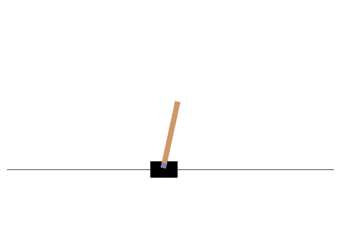

---DONE!---
The reward we got was  11.0


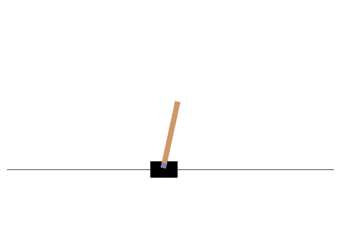

In [10]:
print("----My actor animation-----")
key = jax.random.PRNGKey(int(time.time()))
reward = simulate_cartpole(key, my_actor_policy, 1, True)
print("The reward we got was ", reward)

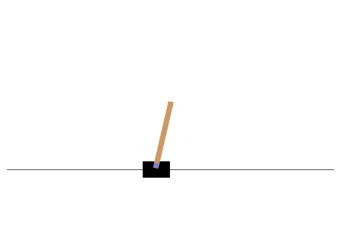

---DONE!---
The reward we got was  10.0


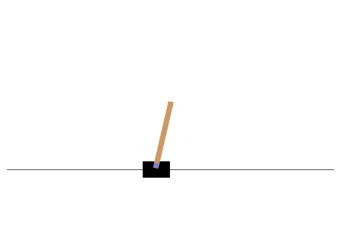

In [11]:
print("----My greedy actor animation-----")
key = jax.random.PRNGKey(int(time.time()))
reward = simulate_cartpole(key, my_greedy_actor_policy, 1, True)
print("The reward we got was ", reward)

# Training using Actor-Critic method

This is an implementation of the one step Actor-Critic training (See pseudo-code below from Sutton and Barto)

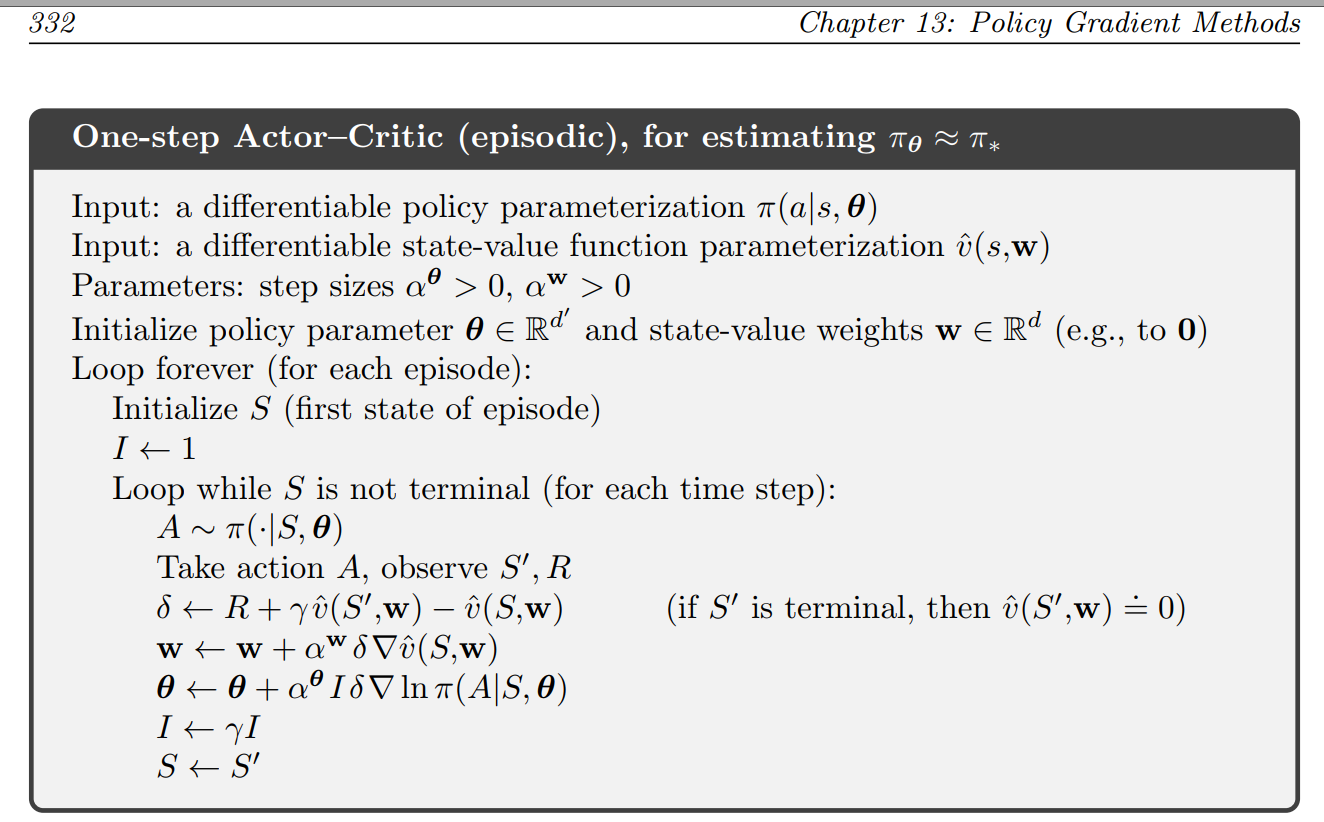

Episode num:  50
Average rewards in last 50 episodes:  20.09804
Episode num:  100
Average rewards in last 50 episodes:  23.509806
Episode num:  150
Average rewards in last 50 episodes:  22.431374
Episode num:  200
Average rewards in last 50 episodes:  30.254904
Episode num:  250
Average rewards in last 50 episodes:  43.980392
Episode num:  300
Average rewards in last 50 episodes:  62.39216
Episode num:  350
Average rewards in last 50 episodes:  66.47059
Episode num:  400
Average rewards in last 50 episodes:  70.70589
Episode num:  450
Average rewards in last 50 episodes:  74.05882
Episode num:  500
Average rewards in last 50 episodes:  83.4902
Episode num:  550
Average rewards in last 50 episodes:  87.15687
Episode num:  600
Average rewards in last 50 episodes:  97.27451
Episode num:  650
Average rewards in last 50 episodes:  105.411766
Episode num:  700
Average rewards in last 50 episodes:  106.78432
Episode num:  750
Average rewards in last 50 episodes:  125.96079
Episode num:  800
A

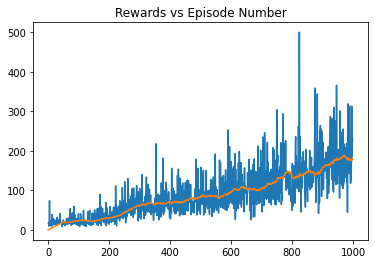

In [12]:
# -------------------------------------------
# Training loop to train the actor and critic
# -------------------------------------------
# This will update the weights for actor and critic to try and find good values that work
# Note: The weights should be initialized from the last block

NUM_EPISODES = 1000
#Takes about 3 minutes in collab to run 1000 episodes

reward_history = np.zeros(NUM_EPISODES)
total_rewards_this_episode = 0
episode_num = 0
jnp.set_printoptions(precision=3, suppress=False)

#Set learning rates and discount factor gamma
gamma = 0.95
lr_actor_init = 0.1
lr_actor = lr_actor_init
lr_critic = 0.1

#Set the OpenAI gym environment
env = gnwrapper.Animation(gym.make('CartPole-v1'))
obs = env.reset()

#Random key used for policy choices
key = jax.random.PRNGKey(0)

#Loop through episodes
while episode_num < NUM_EPISODES:

    #Generate actor policy probs and critic estimate for the current obs
    actor_probs = actor_func(actor_hl_w, actor_hl_b, actor_w, obs)
    critic_value = critic_func(critic_hl_w, critic_hl_b, critic_w, critic_b, obs)
    
    #Choose a random action according to the actor probabilities
    key, subkey = jax.random.split(key)
    action = jax.random.choice(subkey, jnp.array([0,1]), p=actor_probs)
    
    #Get the next state from the environment
    next_obs, reward, done, info = env.step( int(action) )
    total_rewards_this_episode += reward

    #Use the critic to estimate the value of the new state
    #Important! Note that the next_critic_value uses the ground truth of "0" if done==True
    next_critic_value = (1.0-done)*critic_func(critic_hl_w, critic_hl_b, critic_w, critic_b, next_obs)
    
    #Delta is the TD learning difference:
    # difference between what the critic thought the value was with the old info and what it thinks with the new info
    delta = reward + (gamma*next_critic_value) - critic_value

    #Update critic parameters using the critic gradient
    critic_grad = grad_critic_func(critic_hl_w, critic_hl_b, critic_w, critic_b, obs)
    critic_hl_w += lr_critic*delta*critic_grad[0]
    critic_hl_b += lr_critic*delta*critic_grad[1]
    critic_w += lr_critic*delta*critic_grad[2]
    critic_b += lr_critic*delta*critic_grad[3] 

    #Update actor parameters using the gradient of the log_probability of the actor for the action we took
    grad_log_actor = grad_log_actor_funcs[action](actor_hl_w, actor_hl_b, actor_w, obs)
    actor_hl_w += lr_actor*delta*grad_log_actor[0]
    actor_hl_b += lr_actor*delta*grad_log_actor[1]
    actor_w += lr_actor*delta*grad_log_actor[2]

    lr_actor = lr_actor*gamma

    obs = next_obs
    if done:
        lr_actor = lr_actor_init
        reward_history[episode_num] = total_rewards_this_episode

        if episode_num % 50 == 0 and episode_num > 0:
          print("Episode num: ", episode_num)
          print("Average rewards in last 50 episodes: ", jnp.mean(reward_history[episode_num-50:episode_num+1]))
       
        total_rewards_this_episode = 0
        episode_num += 1
        obs = env.reset()


def rolling_average(x, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(x, window, 'full')[0:len(x)]

plt.title("Rewards vs Episode Number")
plt.plot(reward_history)
plt.plot(rolling_average(reward_history,50))

## Testing out actor policy AFTER training

In [13]:
#Simulate N_episodes and output the average reward
N_episodes = 10

print("Simulating ", N_episodes, " episodes of my actor...")
key = jax.random.PRNGKey(0)
average_reward = simulate_cartpole(key, my_actor_policy, N_episodes, False)
print("Average reward over ", N_episodes," episodes is ", average_reward)

print("--------------")

print("Simulating ", N_episodes, " episodes of my greedy actor...")
key = jax.random.PRNGKey(0)
average_reward = simulate_cartpole(key, my_greedy_actor_policy, N_episodes, False)
print("Average reward over ", N_episodes," episodes is ", average_reward)

Simulating  10  episodes of my actor...
Average reward over  10  episodes is  174.4
--------------
Simulating  10  episodes of my greedy actor...
Average reward over  10  episodes is  321.2


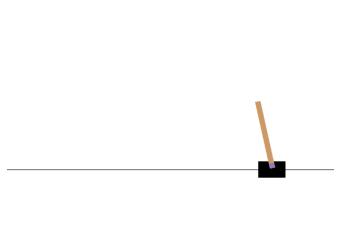

---DONE!---
The reward we got was  158.0


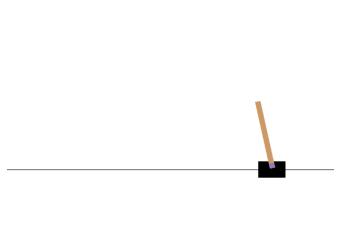

In [14]:
#Simulate 1 epsiode and animate it!
print("----My actor animation-----")
key = jax.random.PRNGKey(int(time.time()))
reward = simulate_cartpole(key, my_actor_policy, 1, True)
print("The reward we got was ", reward)

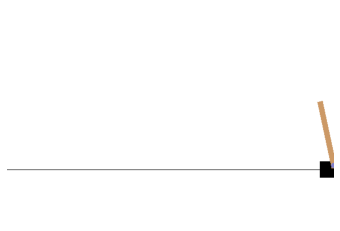

---DONE!---
The reward we got was  390.0


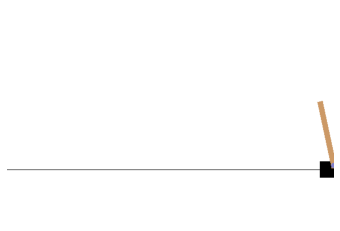

In [15]:
print("----My greedy actor animation-----")
key = jax.random.PRNGKey(int(time.time()))
reward = simulate_cartpole(key, my_greedy_actor_policy, 1, True)
print("The reward we got was ", reward)